## Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, RepeatVector
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Dataset

### Importing Dataset

In [2]:
# Downloading the data
aapl_df = yf.download('AAPL')
aapl_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600


### Data Preprocessing

In [3]:
# Adding a column 'Prediction' which is shifted by 1 day
aapl_df['Prediction'] = aapl_df['Close'].shift(-1)

# Removing NA values
aapl_df = aapl_df.dropna()

aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume,Prediction
Date,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600,0.121652
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800,0.112723
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000,0.115513
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600,0.118862
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600,0.126116


In [4]:
# Extract dates for the test dataset
x_date = aapl_df.index[-math.ceil(len(aapl_df) * 0.2):]

In [5]:
in_scaler = MinMaxScaler()
out_scaler = MinMaxScaler()

# Scaling the data
x = in_scaler.fit_transform(aapl_df.drop(['Prediction'], axis=1))
y = out_scaler.fit_transform(aapl_df.drop(
    ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1))


### Creating Dataset

In [6]:
sequence_length = 42
train_len = math.ceil(len(aapl_df) * 0.6)
val_len = math.ceil(len(aapl_df) * 0.2)

# Splitting the data into train, validation and test dataset
x_train = x[:train_len, :]
y_train = y[:train_len, :]

x_val = x[train_len - sequence_length:train_len + val_len, :]
y_val = y[train_len - sequence_length:train_len + val_len, :]

x_test = x[train_len + val_len - sequence_length:, :]
y_test = y[train_len + val_len - sequence_length:, :]

In [7]:
def create_dataset(x, y, sequence_length):
    x_data = []
    y_data = []
    for i in range(sequence_length, len(x)):
        x_data.append(x[i - sequence_length:i, :])
        y_data.append(y[i, :])
    return np.array(x_data), np.array(y_data)


# Creating the dataset
x_train, y_train = create_dataset(x_train, y_train, sequence_length)
x_val, y_val = create_dataset(x_val, y_val, sequence_length)
x_test, y_test = create_dataset(x_test, y_test, sequence_length)

## Model Building and Training

In [8]:
def MSLSTMA():
    model = Sequential()
    n_neurons = x_train.shape[1] * x_train.shape[2]
    model.add(LSTM(n_neurons, return_sequences=False,
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(RepeatVector(n_neurons))
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(6))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [9]:
model = MSLSTMA()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 252)               261072    
                                                                 
 repeat_vector (RepeatVector  (None, 252, 252)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 252)               509040    
                                                                 
 dense (Dense)               (None, 6)                 1518      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 771,637
Trainable params: 771,637
Non-trainable params: 0
__________________________________________________

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('../Saved Models/mslstma.h5',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

epochs = 100
batch_size = 16

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, checkpoint],
)

Epoch 1/100
396/396 [==============================] - ETA: 0s - loss: 1.1332e-05
Epoch 00001: val_loss improved from inf to 0.00001, saving model to mslstma.h5
396/396 [==============================] - 13s 24ms/step - loss: 1.1332e-05 - val_loss: 6.2156e-06
Epoch 2/100
393/396 [============================>.] - ETA: 0s - loss: 8.6130e-08
Epoch 00002: val_loss did not improve from 0.00001
396/396 [==============================] - 7s 19ms/step - loss: 8.5909e-08 - val_loss: 1.3657e-05
Epoch 3/100
395/396 [============================>.] - ETA: 0s - loss: 9.4459e-08
Epoch 00003: val_loss did not improve from 0.00001
396/396 [==============================] - 8s 19ms/step - loss: 9.4389e-08 - val_loss: 8.1046e-06
Epoch 4/100
394/396 [============================>.] - ETA: 0s - loss: 8.5660e-08
Epoch 00004: val_loss did not improve from 0.00001
396/396 [==============================] - 7s 19ms/step - loss: 8.5527e-08 - val_loss: 9.5447e-06
Epoch 5/100
396/396 [==========================

## Model Evaluation

In [13]:
model = MSLSTMA()
model.load_weights('../Saved Models/mslstma.h5')

In [14]:
predicitons = model.predict(x_test)
predictions = out_scaler.inverse_transform(predicitons)
actual = out_scaler.inverse_transform(y_test)

# Calculating the error
error = predictions - actual
mse = np.square(error).mean()
rmse = np.sqrt(mse)
mae = np.abs(error).mean()
mape = np.abs(error / actual).mean() * 100

# Printing the error
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)

67/67 [==============================] - 27s 382ms/step
Mean Squared Error:  10.091533608036334
Root Mean Squared Error:  3.1767174265326674
Mean Absolute Error:  1.9902242129555414
Mean Absolute Percentage Error:  2.7020369557118262


## Model Prediction and Visualization

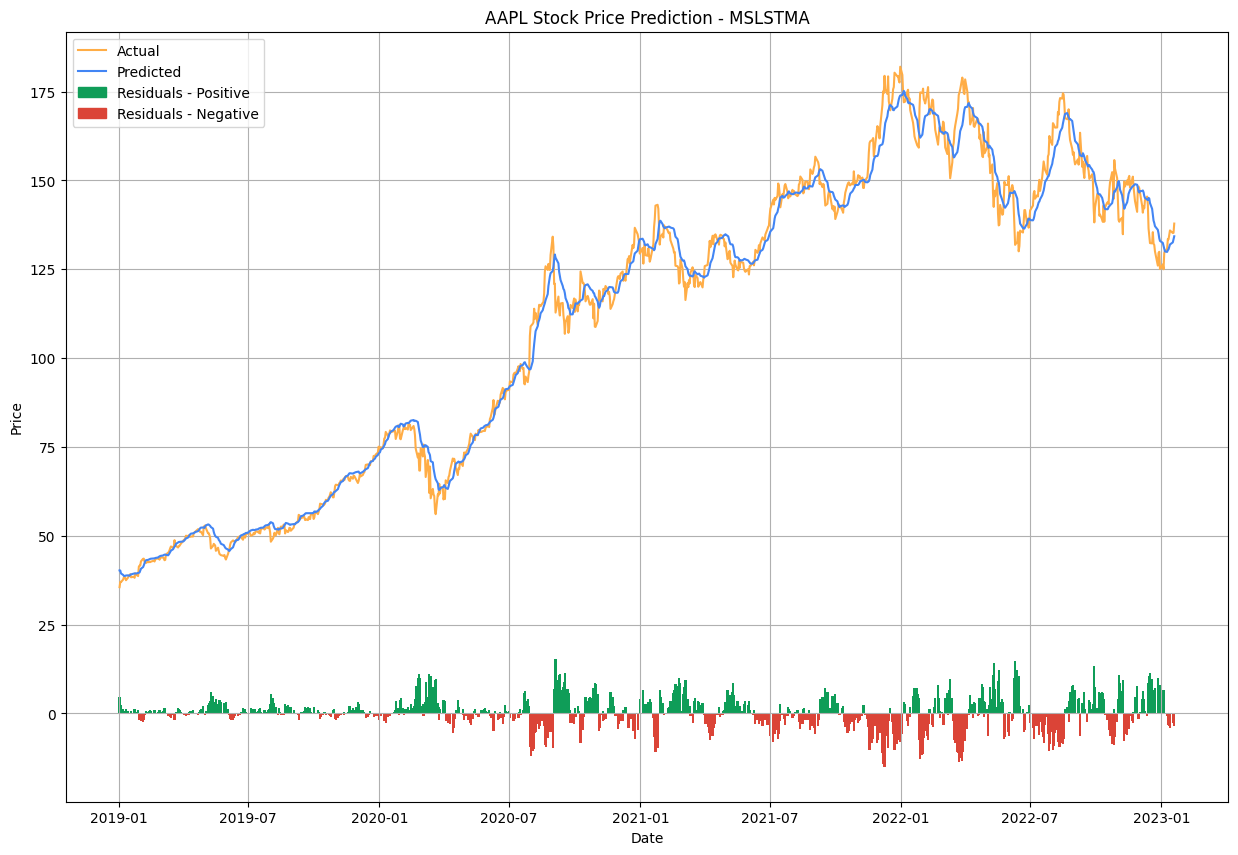

In [15]:
# Creating a dataframe for the predictions, actual values and residuals
prediction_df = pd.DataFrame({'Actual': actual.flatten(
), 'Predicted': predictions.flatten(), 'Residuals': error.flatten()}, index=x_date)

# Taking data from 2019-01-01
predictions_df = prediction_df.loc['2019-01-01':]

# Plotting the data and residuals bars in the same plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(predictions_df.index,
        predictions_df['Actual'], label='Actual', color='#FFAD46', linewidth=1.5)
ax.plot(predictions_df.index,
        predictions_df['Predicted'], label='Predicted', color='#4285F4', linewidth=1.5)

df_sub = ["#0F9D58" if x >
          0 else "#DB4437" for x in predictions_df["Residuals"].dropna()]
ax.bar(predictions_df.index, predictions_df['Residuals'].dropna(
), width=3, label='Residuals', color=df_sub)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('AAPL Stock Price Prediction - MSLSTMA')

Patch = mpatches.Patch
legend_elements = [Line2D([0], [0], color='#FFAD46', lw=1.5, label='Actual'),
                   Line2D([0], [0], color='#4285F4',
                          lw=1.5, label='Predicted'),
                   Patch(facecolor='#0F9D58', edgecolor='#0F9D58',
                         label='Residuals - Positive'),
                   Patch(facecolor='#DB4437', edgecolor='#DB4437', label='Residuals - Negative')]
ax.legend(handles=legend_elements, loc='upper left')

ax.grid(True)
plt.show()